In [1]:
# Quick redo of what we did last time
# maybe do it in 3d now ? 

In [2]:
# What we did last time:
# - Choose a function to generate some data, add some noise to it. This is our training data
# - Run a GP to find something close to the function that we used to generate that data basically is the idea

### The Gramacy & Lee (2012) Function 
$$
f(x) = \frac{\sin(10\pi x)}{2x} + (x - 1)^4
$$

We take it for $x \in [0.5 , 2.5]$

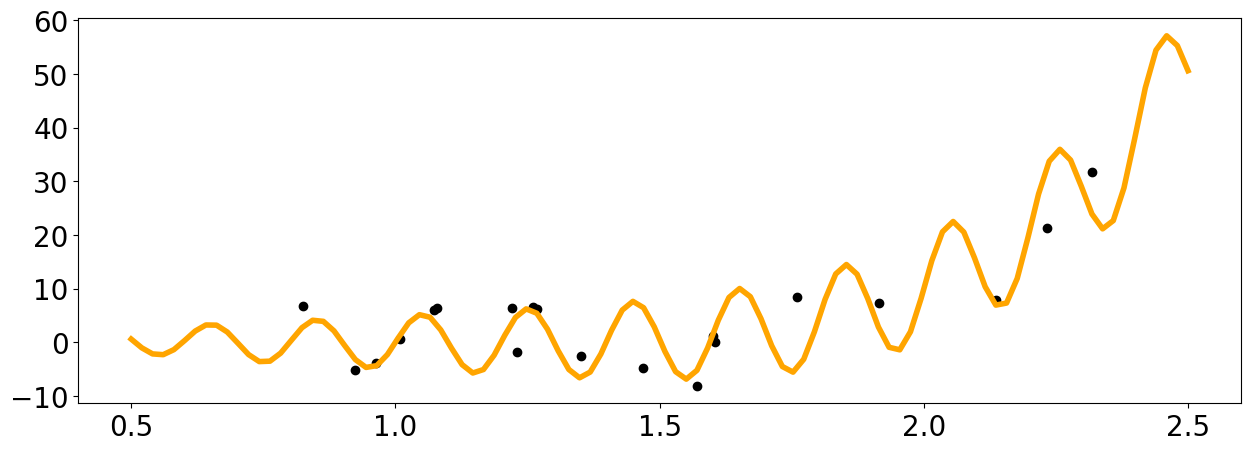

In [202]:
import numpy as np
import matplotlib.pyplot as plt
import random
from fvgp import GP
from itertools import product        # what does this do ?


#########################
## Getting Data for GP ##
#########################


# Generate x_data and x_few_points
x_data = 0.5 + (2.5 - 0.5) * np.random.rand(20).reshape(-1, 1)
x_pred1D = np.linspace(0.5,2.5,100).reshape(-1,1) # What is this and why do we need it ? Can't we just have x_data ?

# Gramacy & Lee (2012) function
def grlee(x):
    return (np.sin(10 * np.pi * x) / 2 * x) + (x - 1)**4

# Function to generate noise
def data_for_noise(lower_bound=-1, upper_bound=1):
    return np.random.normal()
 
# Function to add noise to the Gramacy & Lee function
def grlee_with_noise(x, lower_bound=-1, upper_bound=1):
    return grlee(x) + data_for_noise()

# Generate de y_data
# y_data = np.array(grlee_with_noise(x_data))
y_data = grlee(x_data[:,0]) + (np.random.normal(0,0.5, len(x_data))) # * 0.5

y_data *= 10

# Plotting the data
plt.figure(figsize=(15, 5))
plt.plot(x_pred1D, 10 * grlee(x_pred1D), color='orange', linewidth=4)
plt.scatter(x_data, y_data, color='black')

plt.xticks([0.5, 1.0, 1.5, 2.0, 2.5])
# plt.yticks([-2, -1, 0, 1, 2, 5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()


# Note: I didn't do .reshape(-1,1) here, and it works. I tried doing it and it had a size error, so make of that what you will

In [138]:
#####################################################
## Choosing noise, kernel and mean funciton for GP ##
#####################################################
from fvgp.gp_kernels import * 

hyperparameters = np.array([
                   1, # length scale
                   1, # signal variance,
                   1, # gp noise
                   3, # mean function
])


def my_noise(x,hyps=hyperparameters):
    return np.diag(np.ones((len(x))) * hyps[2])

# RBF or Gaussian Kernel
# def rbf_kernel(x1,x2,hyps=hyperparameters):

#     sigma2 = hyperparameters[1]
#     l = hyperparameters[0]
#     return sigma2 * np.exp((-1/2) * ((x1 - x2)/l)** 2)



# Here we define a zero-mean function, bala ma etfalsaf
def my_mean(x=0, hyps=hyperparameters):
    # return 0          # This didn't work ... ? 
    return np.sin(hyps[3] * x[:,0])
    # return np.zeros_like(x)


The kernel I used is the 1-dimensional Radial Basis Function also known as the Gaussian kernel
$$
K(x_1,x_2|\text{hyps}) = \sigma^2 \exp(-\frac{1}{2}(\frac{x_1 - x_2}{l})^2) 
$$

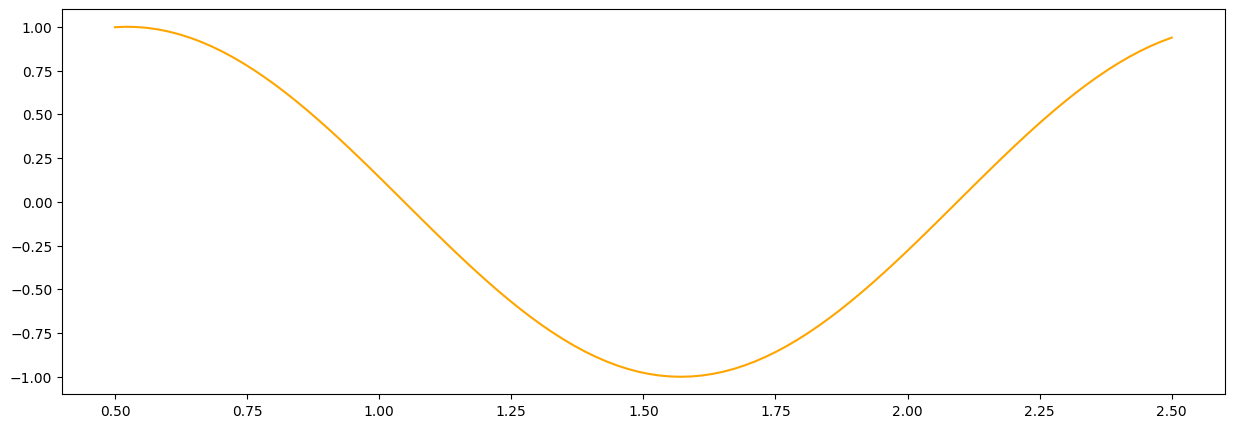

In [139]:
# It is a good idea to plot the prior mean function to make sure we did not mess up
plt.figure(figsize = (15,5))
plt.plot(x_pred1D, my_mean(x_pred1D, hyperparameters), color = 'orange', label = 'task1')

In [272]:
# does the hps[2] or noise hyperparameter also get trained by the gp ?

my_gp1 = GP(x_data, y_data, 
            init_hyperparameters=hyperparameters,
            noise_variances=None, #provding noise variances and a noise function will raise a warning 
            compute_device='cpu', 
            # gp_kernel_function=rbf_kernel, 
            gp_kernel_function_grad=None, 
            # gp_mean_function=my_mean, 
            gp_mean_function_grad=None,
            gp_noise_function=my_noise,
            gp2Scale = False,
            calc_inv=False, 
            ram_economy=False, 
            args=None,
            )


hps_bounds = np.array([[1e-5,1000],     # length scale for the kernel          # default kernel function has this as signal variance and vice versa
                       [0.01,5.],      # signal variance for the kernel
                       [0.001,100],     # noise
                       [0.01,60]      # mean
                      ])

my_gp1.train(hyperparameter_bounds=hps_bounds, # max_iter=100,
             init_hyperparameters=hyperparameters)

print("Global Training")
print(my_gp1.get_hyperparameters())

print(my_gp1.log_likelihood())

Global Training
[106.28018022   0.1798942   10.33486931  55.68037901]
-66.27940836194514


10.0272129553393
(11.406339293056412, 10.188091864120183)


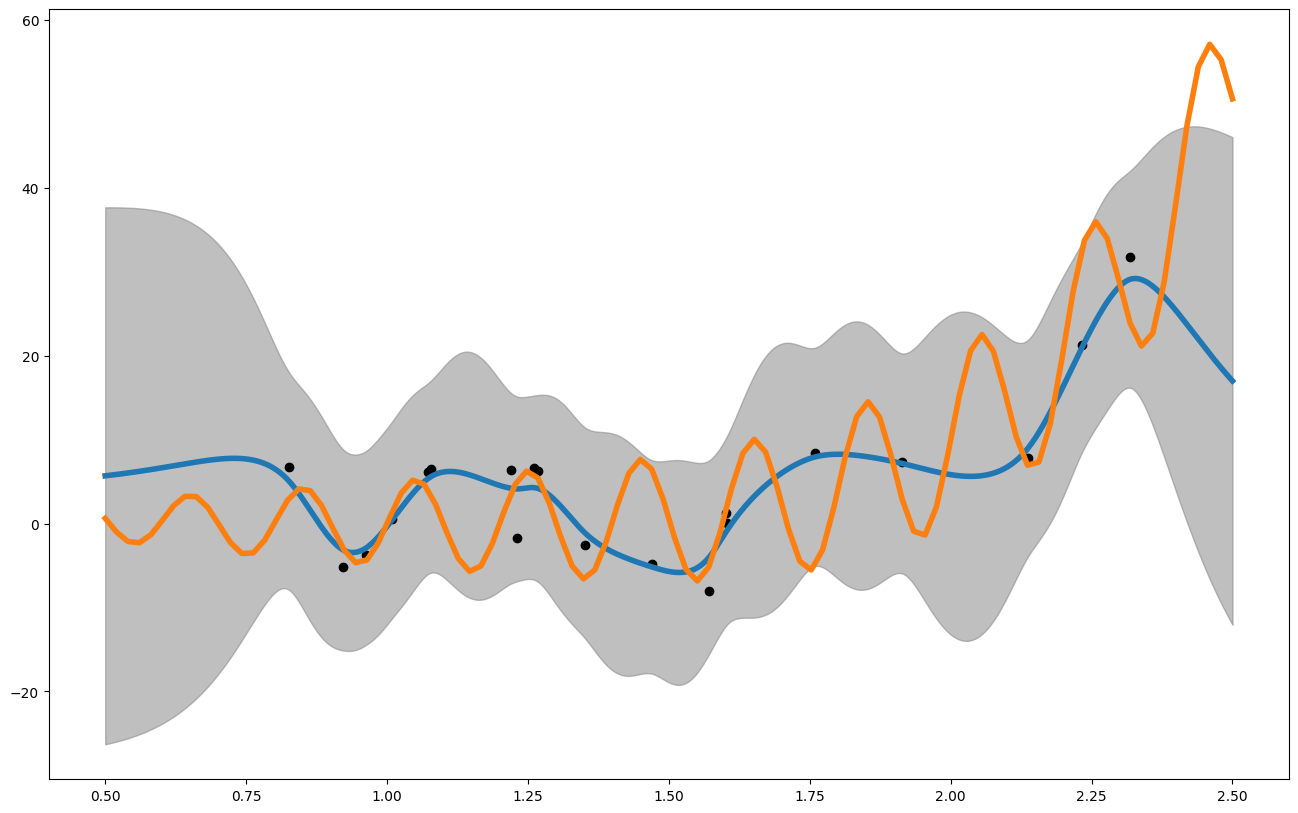

In [257]:
#let's make a prediction
x_pred = np.linspace(0.5,2.5,1000)

mean1 = my_gp1.posterior_mean(x_pred.reshape(-1,1))["f(x)"]
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]

plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x_pred1D,10 * grlee(x_pred1D), label = "latent function", linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
plt.scatter(x_data,y_data, color = 'black')


##looking at some validation metrics
print(my_gp1.rmse(x_pred1D,10 * grlee(x_pred1D)))
print(my_gp1.crps(x_pred1D,10 * grlee(x_pred1D)))